# Model 

In model, MobileNet version 2 is used for base model to extract features, and a fully connect layer is added to get prediction out of these features.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [2]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  
    input_shape=(160, 160, 3),
    include_top=False,
)  

base_model.trainable = False

inputs = keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [3]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Data 

### Load Data
Here data is loaded and horizontally flipped as data is very scarce to fine-tune a deep learning model

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import cv2
import numpy as np
import glob
import os

In [6]:
def get_data(path):
    normal_path = os.path.join(path,'normal')
    cataract_path = os.path.join(path,'cataract')
    
    normal_eyes =glob.glob(normal_path+'/*')
    cataract_eyes =glob.glob(cataract_path+'/*')
    
    n_eyes_imgs = np.array([cv2.resize(cv2.imread(p),(160,160)) for p in normal_eyes])
    c_eyes_imgs = np.array([cv2.resize(cv2.imread(p),(160,160)) for p in cataract_eyes])
    
    n_eyes_imgs = np.vstack((n_eyes_imgs, n_eyes_imgs[:,:,::-1]))
    c_eyes_imgs = np.vstack((c_eyes_imgs, c_eyes_imgs[:,:,::-1]))
    
    return n_eyes_imgs, c_eyes_imgs
    

In [7]:
train_normal_eyes_imgs, train_cataract_eyes_imgs = get_data('/home/akash/WFH/Cataract/Data/Train/')
print(train_normal_eyes_imgs.shape[0], train_cataract_eyes_imgs.shape[0])

1000 1000


In [8]:
test_normal_eyes_imgs, test_cataract_eyes_imgs = get_data('/home/akash/WFH/Cataract/Data/Test/')
print(test_normal_eyes_imgs.shape[0], test_cataract_eyes_imgs.shape[0])

36 42


### Augmentation
Data is augmented using different techniques, like rotation augmentation, guassian, sheer, contrast and scale augmentation.

In [9]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

#### Techniques of Augmentations

- Rotation

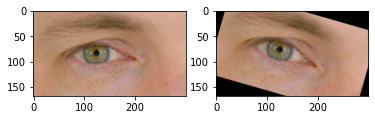

In [10]:
img = cv2.imread('test.jpeg')
rotate=iaa.Affine(rotate=(-50, 30))
output = rotate.augment_image(img)

subplot(1,2,1)
imshow(img[:,:,::-1])
subplot(1,2,2)
imshow(output[:,:,::-1])

- Guassian

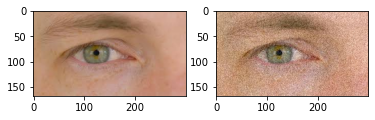

In [11]:
img = cv2.imread('test.jpeg')
augmentation=iaa.AdditiveGaussianNoise(10,20)
output = augmentation.augment_image(img)

subplot(1,2,1)
imshow(img[:,:,::-1])
subplot(1,2,2)
imshow(output[:,:,::-1])

- Sheer

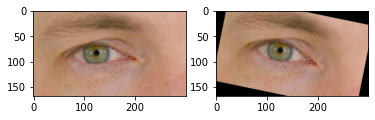

In [12]:
img = cv2.imread('test.jpeg')
augmentation=iaa.Affine(shear=(0,40))
output = augmentation.augment_image(img)

subplot(1,2,1)
imshow(img[:,:,::-1])
subplot(1,2,2)
imshow(output[:,:,::-1])

- Contrast

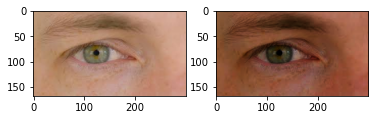

In [13]:
img = cv2.imread('test.jpeg')
augmentation=iaa.GammaContrast(gamma=2.0)
output = augmentation.augment_image(img)

subplot(1,2,1)
imshow(img[:,:,::-1])
subplot(1,2,2)
imshow(output[:,:,::-1])

- Scale

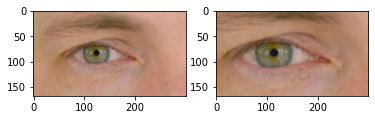

In [14]:
img = cv2.imread('test.jpeg')
augmentation=iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)})
output = augmentation.augment_image(img)

subplot(1,2,1)
imshow(img[:,:,::-1])
subplot(1,2,2)
imshow(output[:,:,::-1])

In [15]:
def rotate_imgs(array):
    
    output = np.zeros_like(array)
    rotate=iaa.Affine(rotate=(-50, 30))
    for i in range(array.shape[0]):
        output[i]=rotate.augment_image(array[i])
   
    return output


def guassian(array):
    
    gaussian_noise=iaa.AdditiveGaussianNoise(10,20)
    output = np.zeros_like(array)
    for i in range(array.shape[0]):
        output[i]=gaussian_noise.augment_image(array[i])
   
    return output

def sheer(array):
    
    shear = iaa.Affine(shear=(0,40))
    output = np.zeros_like(array)
    for i in range(array.shape[0]):
        output[i]=shear.augment_image(array[i])
   
    return output

def contrast(array):
    
    contrast=iaa.GammaContrast(gamma=2.0)
    output = np.zeros_like(array)
    for i in range(array.shape[0]):
        output[i]=contrast.augment_image(array[i])
   
    return output
    
def scale(array):
    
    scale_im=iaa.Affine(scale={"x": (1.5, 1.0), "y": (1.5, 1.0)})
    output = np.zeros_like(array)
    for i in range(array.shape[0]):
        output[i]=scale_im.augment_image(array[i])
        
    return output



In [16]:
def augmentet_it(array):
    rotated_n_eyes = rotate_imgs(array)
    guassian_n_eyes = guassian(array)
    sheer_n_eyes = sheer(array)
    contrast_n_eyes = contrast(array)
    scale_n_eyes = scale(array)
    
    return np.vstack((array, rotated_n_eyes, guassian_n_eyes, sheer_n_eyes, contrast_n_eyes, scale_n_eyes))



In [17]:
def augment_and_concate(n_eyes, c_eyes):
    n_eyes_aug = augmentet_it(n_eyes)
    c_eyes_aug = augmentet_it(c_eyes)
    
    y_normal = np.zeros(n_eyes_aug.shape[0])
    y_cataract = np.ones(c_eyes_aug.shape[0])
    
    x = np.vstack((n_eyes_aug, c_eyes_aug))
    y = np.hstack((y_normal, y_cataract))
    
    return x,y
    

In [18]:
x_train, y_train = augment_and_concate(train_normal_eyes_imgs, train_cataract_eyes_imgs)
x_test, y_test = augment_and_concate(test_normal_eyes_imgs, test_cataract_eyes_imgs)


In [19]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(12000, 160, 160, 3) (12000,)
(468, 160, 160, 3) (468,)


In [20]:
def shuffle(x_train, y_train):
    idx = np.arange(x_train.shape[0])
    np.random.shuffle(idx)
    return x_train[idx], y_train[idx]


In [21]:
x_train, y_train = shuffle(x_train, y_train)

1.0


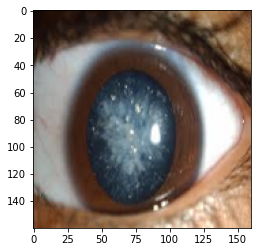

In [22]:
idx = np.random.randint(0, x_train.shape[0])
print(y_train[idx])
imshow(x_train[idx,:,:,::-1])

In [23]:
x_train = x_train/255.0
x_test = x_test/255.0

In [24]:
print(x_train.shape,y_train.shape, x_test.shape, y_test.shape)

(12000, 160, 160, 3) (12000,) (468, 160, 160, 3) (468,)


### Model Traning

Training of model on augmented and normalized data done above

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=200, validation_data=(x_test,y_test))

Epoch 1/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5537 - accuracy: 0.8973 - val_loss: 0.5449 - val_accuracy: 0.9081
Epoch 2/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5540 - accuracy: 0.8973 - val_loss: 0.5443 - val_accuracy: 0.9081
Epoch 3/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5524 - accuracy: 0.8993 - val_loss: 0.5452 - val_accuracy: 0.9145
Epoch 4/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5519 - accuracy: 0.8998 - val_loss: 0.5449 - val_accuracy: 0.9124
Epoch 5/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5508 - accuracy: 0.9055 - val_loss: 0.5458 - val_accuracy: 0.9124
Epoch 6/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5512 - accuracy: 0.9035 - val_loss: 0.5452 - val_accuracy: 0.9124
Epoch 7/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5506 - accuracy: 0.9049 - val_loss: 0.5464 - val_accuracy: 0.9081

Epoch 58/200
750/750 [==============================] - 5s 7ms/step - loss: 0.5438 - accuracy: 0.9149 - val_loss: 0.5494 - val_accuracy: 0.8932
Epoch 59/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5437 - accuracy: 0.9134 - val_loss: 0.5476 - val_accuracy: 0.9017
Epoch 60/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5417 - accuracy: 0.9198 - val_loss: 0.5489 - val_accuracy: 0.8996
Epoch 61/200
750/750 [==============================] - 6s 8ms/step - loss: 0.5427 - accuracy: 0.9176 - val_loss: 0.5478 - val_accuracy: 0.8974
Epoch 62/200
652/750 [=========================>....] - ETA: 0s - loss: 0.5433 - accuracy: 0.9184

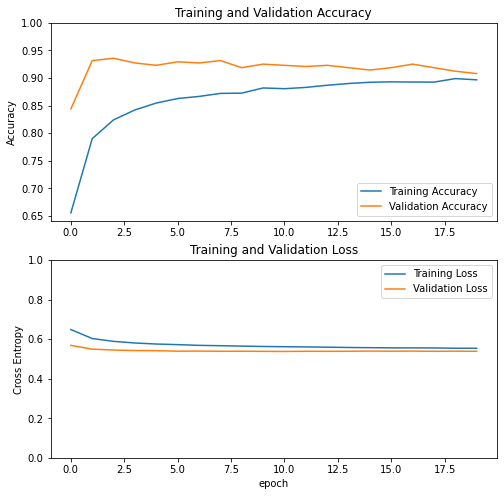

In [26]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
y_pred_class = model.predict(x_test)
y_pred_class[y_pred_class<0.5]=0
y_pred_class[y_pred_class>=0.5]=1
cm=confusion_matrix(y_test,y_pred_class)

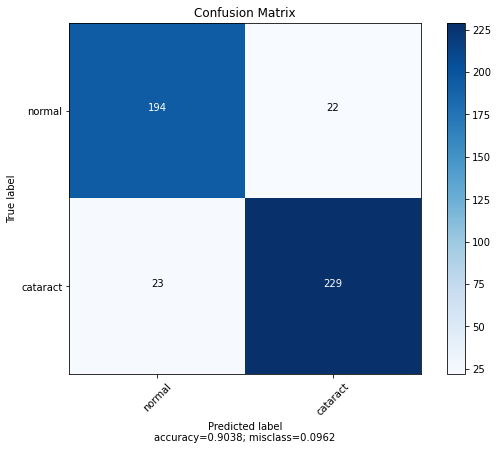

In [49]:
plot_confusion_matrix(cm           ,
                      normalize    = False,
                      target_names = ['normal', 'cataract'],
                      title        = "Confusion Matrix")

In [50]:
## to save model 
model.save('final-700imgs.h5')

### Model Testing

Here is the code to test the trained model.

In [51]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/akash/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [52]:
import tensorflow as tf
from tensorflow import keras
import cv2

In [53]:
model=keras.models.load_model('final-700imgs.h5')

In [55]:
img = cv2.imread('test.jpeg')
# img = cv2.imread('/home/akash/WFH/Cataract/Data/Test/normal/002.jpeg')
img.shape

(168, 300, 3)

In [56]:
resized = cv2.resize(img, (160,160))
resized.shape

(160, 160, 3)

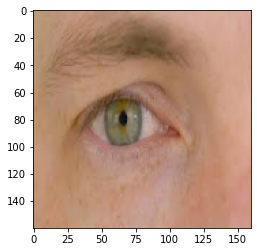

In [57]:
imshow(resized[:,:,::-1])

In [58]:
resized.shape
input_img = resized.reshape((1,)+resized.shape)
print(input_img.shape)

(1, 160, 160, 3)


In [59]:
output = model.predict(input_img/255.0)
print(output)
print("Cataract" if output>=0.5 else "Normal")

[[0.8065021]]
Cataract
